<a href="https://colab.research.google.com/github/Khadijah-Trawally/QuantumGraphColoring/blob/main/test_graph_coloring_hamiltonian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import time
import os

import numpy as np

import matplotlib.pyplot as plt
from scipy.linalg import eigh
import networkx as nx


In [10]:
def draw_graph(N, edges):
    """
    Generate and draw a graph with a given structure

    Parameters
    ----------
    num_nodes : int
        Number of nodes of the graph
    edges : list of tuples of ints
        Edges of the graph

    Returns
    -------
    nx.Graph
        Graph object
    """
    graph = nx.Graph()
    graph.add_nodes_from([ii for ii in range(N)])
    graph.add_edges_from(edges)
    nx.draw(graph, with_labels=True, node_size=700)


    return graph

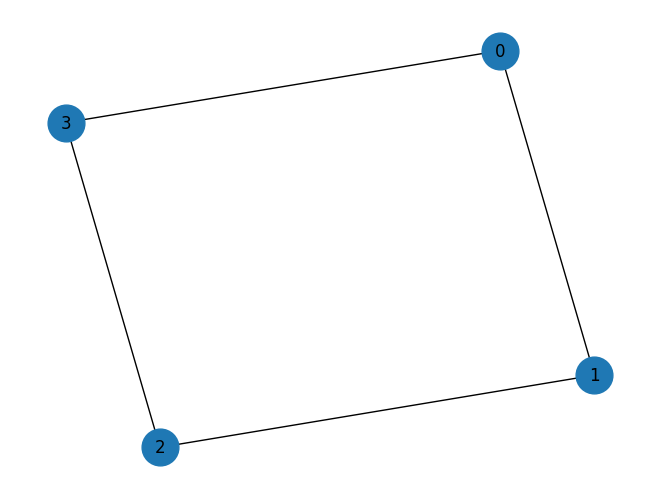

In [11]:
edges = [(0, 1), (1, 2), (2, 3), (0 , 3)]
num_nodes = 4


G = draw_graph(num_nodes, edges)
G



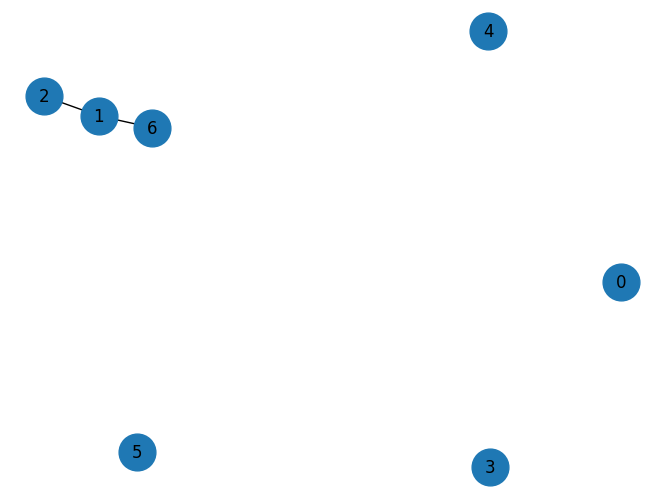

In [12]:
edges_rant = [(1, 2), (1,
                       6)]
num_nodes = 6
draw_graph(num_nodes, edges_rant)

In [13]:
def get_1d_index(i, k, c):
    """
    Convert 2D index (i, k) to a 1D index in a grid with 'c' number of columns.

    Parameters:
    i (int): Node index.
    k (int): Color index.
    c (int): Number of colors.

    Returns:
    int: Corresponding 1D index.
    """
    return i * c + k

def magnetic_fields(N, C, graph, lambda1, lambda2):
    """
    Construct the magnetic fields h for the Hamiltonian.

    Parameters:
    N (int): Number of nodes.
    graph (networkx.Graph): Graph representing the nodes and edges.
    C (int): Number of colors.
    lambda1 (float): Coefficient for the first two terms.
    lambda2 (float): Coefficient for the third term.

    Returns:
    numpy.ndarray: Magnetic fields vector.
    """
    # sigmaz = np.array([[1, 0], [0, -1]], dtype=complex)
    dim = N * C
    h = np.zeros(dim, dtype=complex)

    # First term: (1/2) * lambda1 * sum_{i=1}^{n} sum_{k=1}^{c} (c-k-1) * sigma_{ik}
    for i in range(N):
        for k in range(C):
            ik = get_1d_index(i, k, C)
            coefficient = (C - k - 1)
            h[ik] += 0.5 * lambda1 * coefficient

    # Second term: (1/2) * lambda1 * sum_{i=1}^{n} sum_{k' > k=1}^{c} sigma_{ik'}
    for i in range(N):
        for k in range(C - 1):
            for k_prime in range(k + 1, C):
                ik_prime = get_1d_index(i, k_prime, C)
                h[ik_prime] += 0.5 * lambda1

    # Third term: (1/4) * lambda2 * sum_{(i,j) in E} sum_{k=1}^{c} (sigma_{ik} + sigma_{jk})
    for i, j in graph.edges:
        for k in range(C):
            ik = get_1d_index(i, k, C)
            jk = get_1d_index(j, k, C)
            h[ik] += 0.25 * lambda2
            h[jk] += 0.25 * lambda2

    return h

def interaction_strengths(N, C, graph, lambda1, lambda2):
    """
    Construct the interaction strengths matrix J.

    Parameters:
    N (int): Number of nodes.
    C (int): Number of colors.
    graph (networkx.Graph): Graph representing the nodes and edges.
    lambda1 (float): Coefficient for the first term.
    lambda2 (float): Coefficient for the second term.

    Returns:
    numpy.ndarray: Interaction strengths matrix J.
    """
    dim = N * C
    J = np.zeros((dim, dim), dtype=complex)

    # First term: (1/2) * lambda1 * sum_{i=1}^{n} sum_{k' > k=1}^{c} sigma_{ik} sigma_{ik'}
    for i in range(N):
        for k in range(C - 1):
            for k_prime in range(k + 1, C):
                ik = get_1d_index(i, k, C)
                ik_prime = get_1d_index(i, k_prime, C)
                J[ik, ik_prime] = 0.5 * lambda1

    # Second term: (1/4) * lambda2 * sum_{(i,j) in E} sum_{k=1}^{c} sigma_{ik} sigma_{jk}
    for i, j in graph.edges:
        for k in range(C):
            ik = get_1d_index(i, k, C)
            jk = get_1d_index(j, k, C)
            J[ik, jk] = 0.25 * lambda2

    return J



if __name__ == "__main__":
    n = 4  # Number of nodes
    c = 2  # Number of colors
    lambda1 = 4.0
    lambda2 = 2.0

    # Construct the magnetic fields
    h = magnetic_fields(n, c, G, lambda1, lambda2)

    # Construct the interaction strengths matrix
    J = interaction_strengths(n, c, G, lambda1, lambda2)

    print("Interaction strengths matrix J:\n", J)

    print("Magnetic fields h:\n", h)


Interaction strengths matrix J:
 [[0. +0.j 2. +0.j 0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 2. +0.j 0.5+0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 2. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 2. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j 0. +0.j]]
Magnetic fields h:
 [3.+0.j 3.+0.j 3.+0.j 3.+0.j 3.+0.j 3.+0.j 3.+0.j 3.+0.j]
